## 03. Model

### Import Data & libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
reves = pd.read_pickle("data/reves.pkl")

In [3]:
reves.head()

,directors,writers,belongs_to_collection,genres,original_language,production_companies,runtime,keywords,release_month,release_weekday,cast_names,revenue_inflated,genres_counter,production_companies_counter,main_actor_genre
0,2.669624e+08,2.669624e+08,7.092380e+07,1.059860e+08,1.188783e+08,2.669624e+08,193.0,2.269225e+08,8.272077e+07,1.408839e+08,1.759860e+08,2.669624e+08,3,1,1.539184e+08
1,1.799046e+08,1.962946e+08,7.092380e+07,1.667151e+08,1.188783e+08,1.799046e+08,105.0,1.175707e+08,1.797448e+08,9.058722e+07,1.799046e+08,1.799046e+08,4,1,1.826323e+08
2,1.298649e+08,1.298649e+08,7.092380e+07,8.279268e+07,1.188783e+08,1.298649e+08,93.0,2.149132e+08,8.251373e+07,1.279176e+08,1.468606e+08,1.298649e+08,2,1,1.539184e+08
3,7.112113e+07,7.112113e+07,7.092380e+07,8.279268e+07,1.188783e+08,4.454915e+07,68.0,1.225954e+08,5.521710e+07,8.316584e+07,4.069436e+07,3.423464e+07,2,2,1.763220e+08
4,2.919561e+06,4.166173e+06,7.092380e+07,7.353105e+07,1.188783e+08,5.839109e+06,117.0,5.842999e+07,5.521710e+07,1.691554e+08,1.052070e+07,5.839109e+06,1,1,1.763220e+08


In [4]:
reves.columns

Index(['directors', 'writers', 'belongs_to_collection', 'genres',
       'original_language', 'production_companies', 'runtime', 'keywords',
       'release_month', 'release_weekday', 'cast_names', 'revenue_inflated',
       'genres_counter', 'production_companies_counter', 'main_actor_genre'],
      dtype='object')

#### Definimos la variable a predecir

In [5]:
y = reves["revenue_inflated"].values
y.shape

(6441,)

### Modelling. 

Explicación del modelo y por qué lo hemos elegido. 
Creacion estructura del modelo (variables, metricas, etc). 

In [6]:
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score

### Creación de la Función para aplicar modelo

Se crea una función que entrena el modelo en función de diferentes variables de entrada. Para cada versión se grafica el mae y el rmse para el train y el test.

La función devuelve 4 métricas:
* Error Abosoluto Medio
* Variance Score
* Score
* Cross Val Score con un cv = 10

Para estas versiones el modelo tiene siempre los mismos parámetros: 
* n_estimators = 250
* max_depth = 3

No realizamos el gridSearchCV ya que ralentizaría bastante la ejecución del notebook. Una vez se analicen todos los resultados de las versiones, se realizará esta parte para obtener el modelo final.

In [7]:
def model_train(input_data):
    
    # obtenemos los datos de entrada al modelo y aplicamos el split
    X = train.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
    
    # definimos el modelo y entrenamos en el train.
    xgbo = XGBRegressor(n_estimators = 250, max_depth = 3)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgbo.fit(X_train, y_train, eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=False)

    # make predictions for test data
    y_pred = xgbo.predict(X_test)

    # evaluate predictions
    error = mean_absolute_error(y_test, y_pred)
    variance_score = explained_variance_score(y_pred, y_test)
    score = xgbo.score(X_test, y_test)
    cross_val = cross_val_score(xgbo, X, y, cv = 10).mean()

    # retrieve performance metrics
    results = xgbo.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    # plot mae
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['mae'], label='Train')
    ax.plot(x_axis, results['validation_1']['mae'], label='Test')
    ax.legend()
    plt.ylabel('mae')
    plt.title('XGBoost mae')
    plt.show()

    # plot rmse
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    plt.ylabel('rmse')
    plt.title('XGBoost rmse')
    plt.show()
    
    return (error, variance_score, score, cross_val)

#### Creacion del dataframe inicial con los resultados

In [8]:
xgbo_results = pd.DataFrame(columns = ["experiment", "mean_absolute_error", "explained_variance_score", "score", "cross_val_score"])

#### Version 0 - All Features

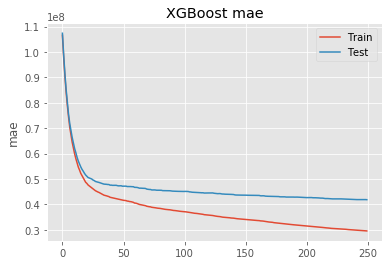

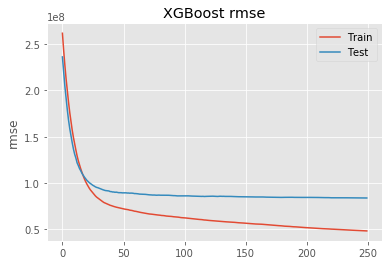

Mean Absolute Error= 41845634.07 
Explained Variance Score = 0.830750 
Score = 0.862327 
Cross Val Score = 0.779014


In [9]:
train = reves.drop(["revenue_inflated"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# save the results in a dataframe
experiment = "All Features"
number_experiment = 0
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 1 - No genres counter

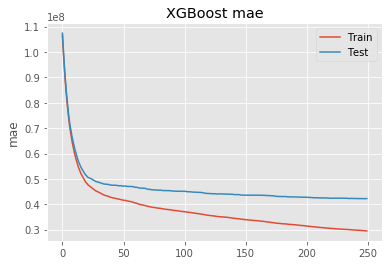

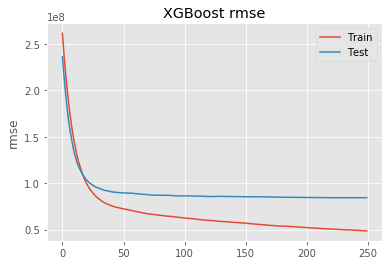

Mean Absolute Error= 42256726.60 
Explained Variance Score = 0.828316 
Score = 0.860964 
Cross Val Score = 0.780163


In [10]:
train = reves.drop(["revenue_inflated", "genres_counter"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# save the results in a dataframe
experiment = "No Genres Counter"
number_experiment = 1
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 2 - No writers

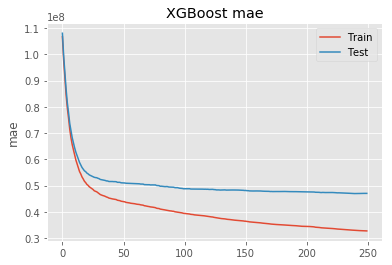

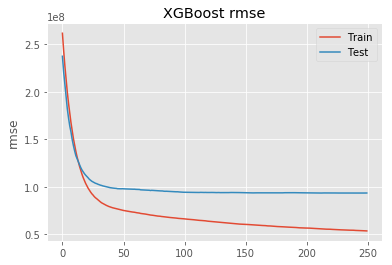

Mean Absolute Error= 47011407.09 
Explained Variance Score = 0.780929 
Score = 0.829481 
Cross Val Score = 0.775567


In [11]:
train = reves.drop(["revenue_inflated", "writers"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# save the results in a dataframe
experiment = "No Writers"
number_experiment = 2
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 3 - No original language

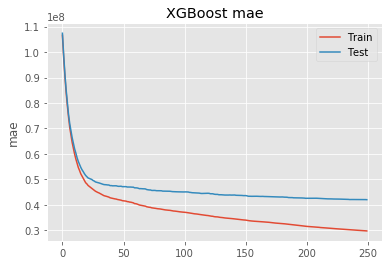

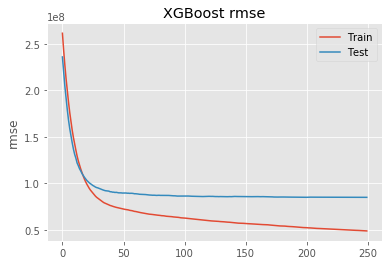

Mean Absolute Error= 42052488.91 
Explained Variance Score = 0.826147 
Score = 0.859351 
Cross Val Score = 0.780175


In [12]:
train = reves.drop(["revenue_inflated", "original_language"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# save the results in a dataframe
experiment = "No Original Language"
number_experiment = 3
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 4 - No release weekday

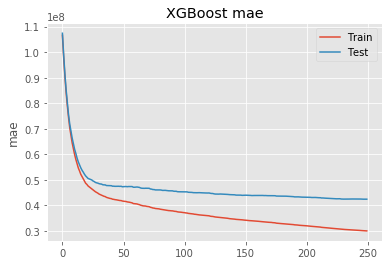

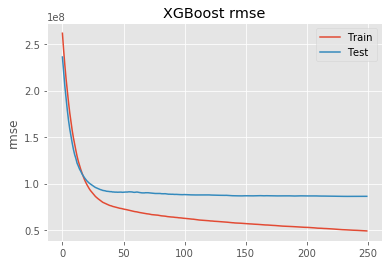

Mean Absolute Error= 42464477.29 
Explained Variance Score = 0.820128 
Score = 0.854274 
Cross Val Score = 0.779773


In [13]:
train = reves.drop(["revenue_inflated", "release_weekday"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# save the results in a dataframe
experiment = "No Release Weekday"
number_experiment = 4
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 5 - No release month

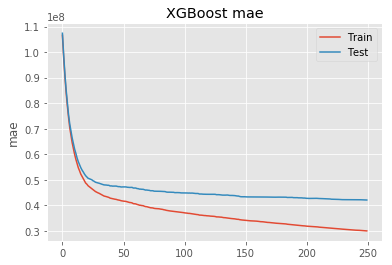

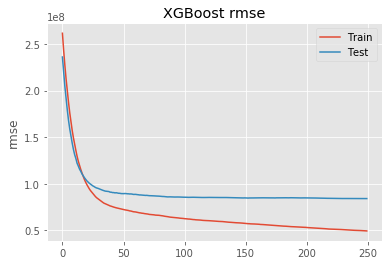

Mean Absolute Error= 42049640.24 
Explained Variance Score = 0.829635 
Score = 0.862224 
Cross Val Score = 0.782320


In [14]:
train = reves.drop(["revenue_inflated", "release_month"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# save the results in a dataframe
experiment = "No Release Month"
number_experiment = 5
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 6 - No production companies counter

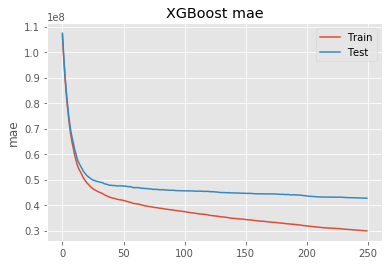

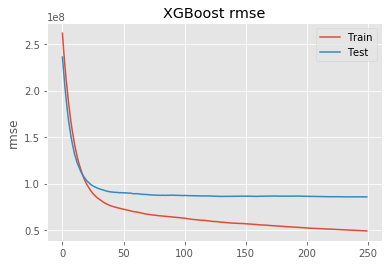

Mean Absolute Error= 42664113.80 
Explained Variance Score = 0.818041 
Score = 0.856237 
Cross Val Score = 0.782015


In [15]:
train = reves.drop(["revenue_inflated", "production_companies_counter"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# save the results in a dataframe
experiment = "No Number of Production Companies"
number_experiment = 6
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 7 - No Main Actor's Genre

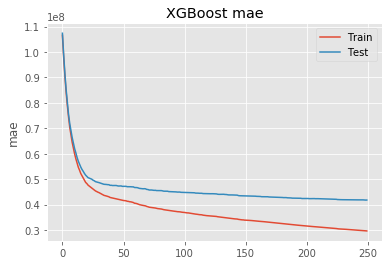

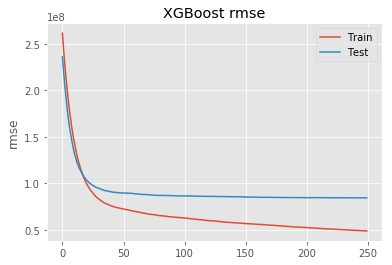

Mean Absolute Error= 41779910.59 
Explained Variance Score = 0.829137 
Score = 0.861047 
Cross Val Score = 0.780481


In [16]:
train = reves.drop(["revenue_inflated", "main_actor_genre"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# save the results in a dataframe
experiment = "No Main Actor's Genre"
number_experiment = 7
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 8 - No runtime

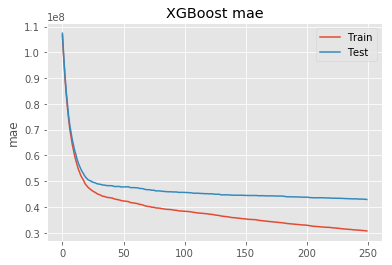

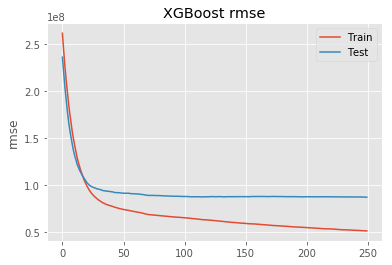

Mean Absolute Error= 42901433.83 
Explained Variance Score = 0.818018 
Score = 0.852713 
Cross Val Score = 0.775490


In [17]:
train = reves.drop(["revenue_inflated", "runtime"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# save the results in a dataframe
experiment = "No Runtime"
number_experiment = 8
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

#### Version 9. No Genres Counter and No Main Actor's Genre

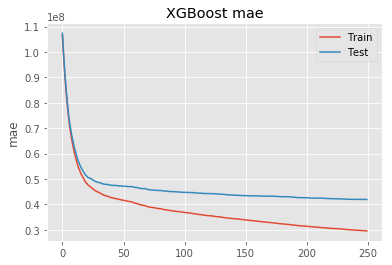

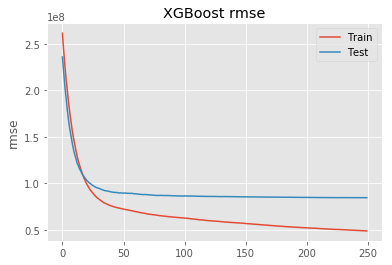

Mean Absolute Error= 41930587.06 
Explained Variance Score = 0.828183 
Score = 0.860358 
Cross Val Score = 0.780753


In [18]:
train = reves.drop(["revenue_inflated", "genres_counter", "main_actor_genre"], axis = 1)
model = model_train(train)
print("Mean Absolute Error= %.2f \nExplained Variance Score = %f \nScore = %f \nCross Val Score = %f" %(model[0], model[1], model[2], model[3]))

# save the results in a dataframe
experiment = "No Genres Counter and No Main Actor's Genre"
number_experiment = 9
row = [experiment, model[0], model[1], model[2], model[3]]
xgbo_results.loc[number_experiment] = row

##   Comparativa de modelos.
Sacar tabla con todos los resultados que hemos ido generando, y comentario/explciación final y elegir 1.

In [19]:
xgbo_results

,experiment,mean_absolute_error,explained_variance_score,score,cross_val_score
0,All Features,4.184563e+07,0.830750,0.862327,0.779014
1,No Genres Counter,4.225673e+07,0.828316,0.860964,0.780163
2,No Writers,4.701141e+07,0.780929,0.829481,0.775567
3,No Original Language,4.205249e+07,0.826147,0.859351,0.780175
4,No Release Weekday,4.246448e+07,0.820128,0.854274,0.779773
5,No Release Month,4.204964e+07,0.829635,0.862224,0.782320
6,No Number of Production Companies,4.266411e+07,0.818041,0.856237,0.782015
7,No Main Actor's Genre,4.177991e+07,0.829137,0.861047,0.780481
8,No Runtime,4.290143e+07,0.818018,0.852713,0.775490
9,No Genres Counter and No Main Actor's Genre,4.193059e+07,0.828183,0.860358,0.780753


En primer lugar vemos que las gráficas del error absoluto media y el error cuadrático medio son muy parecidas en todas las pruebas.

Vemos que el train y el test aprenden rápido. Antes de las 50 primeras épocas. Veremos más tarde con GridSearchCV cuales son los valores más recomendados.

También vemos que las métricas son muy parecidas en todos los experimentos, salvo en el caso en el que no se contaban con los guionistas. Vemos que sin esta variable el error es mayor.

En base a esto decidimos entrenar el modelo para todas las variables y no descartar ninguna ya que es la prueba con mayor score

## Modelo final

Esta parte se realiza lo siguiente:

- GridsearchCV para explicar cuáles son los parametros optimos que utiliza el modelo.
- Se entrena el modelo con todos los datos y se grafican las importancias de las variables.
- Se guarda el modelo en un pkl para su aplicación

In [20]:
X = reves.drop(["revenue_inflated"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
xgbo = GridSearchCV(estimator = XGBRegressor(),
                    param_grid = {"n_estimators" : np.arange(200, 500, 50), "max_depth" : np.arange(3, 6, 1)})
xgbo.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([200, 250, 300, 350, 400, 450]), 'max_depth': array([3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
print(xgbo.best_params_)

{'max_depth': 3, 'n_estimators': 400}


En un principio las gráficas que arriba veíamos con los errores daban a entender que quizá el parámetro óptimo de número de estimadores fuese cercano a 50. Pero ya vemos que el GridSearchCV nos recomienda utilizar 400.

Ahora vamos a entrenar el modelo con todos los datos y graficar que variables son más importantes para el modelo

In [22]:
xgbo = XGBRegressor(n_estimators = 400, max_depth = 3)
xgbo.fit(X, y)
# make predictions for test data
y_pred = xgbo.predict(X_test)

# evaluate predictions
print(mean_absolute_error(y_test, y_pred))
print(explained_variance_score(y_pred, y_test))
print(xgbo.score(X_test, y_test))
print(cross_val_score(xgbo, X, y, cv = 10).mean())

29715379.9537
0.950786460533
0.954596685307
0.779637692305


Primero echemos un vistazo al primer árbol de decisión y ver que hace

In [23]:
from xgboost import to_graphviz

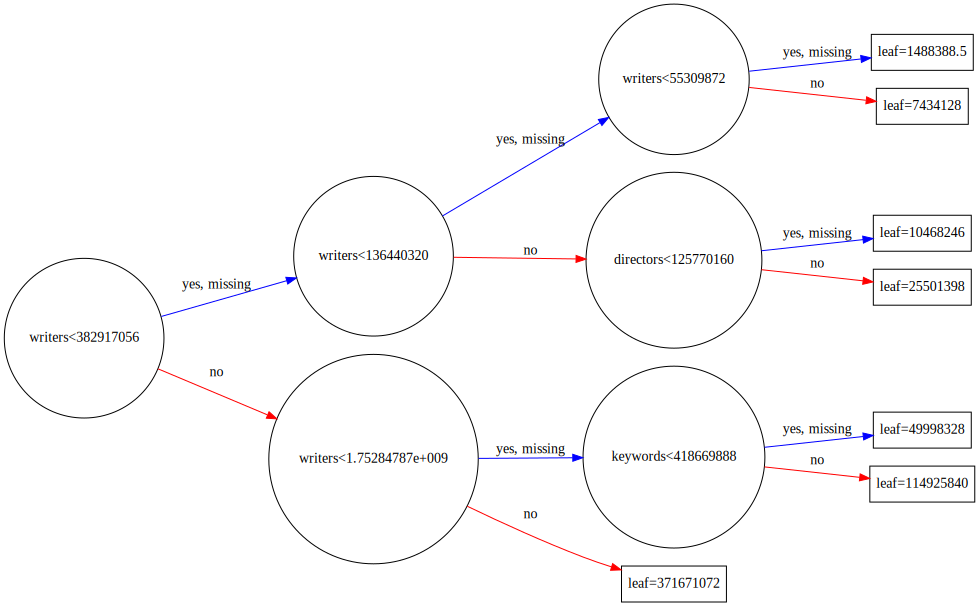

In [24]:
to_graphviz(xgbo, rankdir = "LR", num_trees = 0)

Vemos como para este primer árbol el modelo empieza evaluando el valor de los guionistas y luego combina con valor de las keywords y directores.

For this task we see there are three options for measuring feature importance in XGBoost:

* Weight. The number of times a feature is used to split the data across all trees.
* Gain. The average training loss reduction gained when using a feature for splitting.
* Cover. The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.

In [25]:
from xgboost import plot_importance

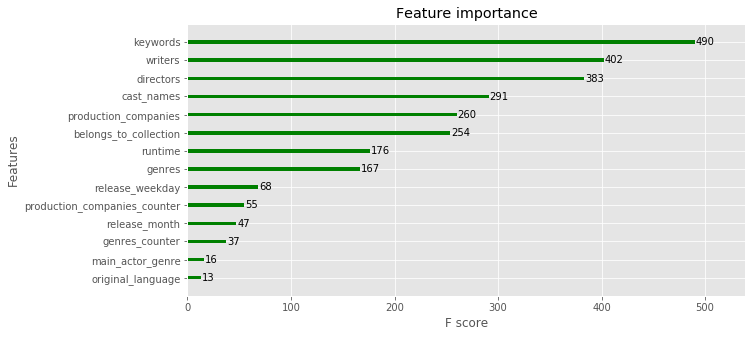

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgbo, ax = ax, importance_type = "weight", color = "green")
plt.show()

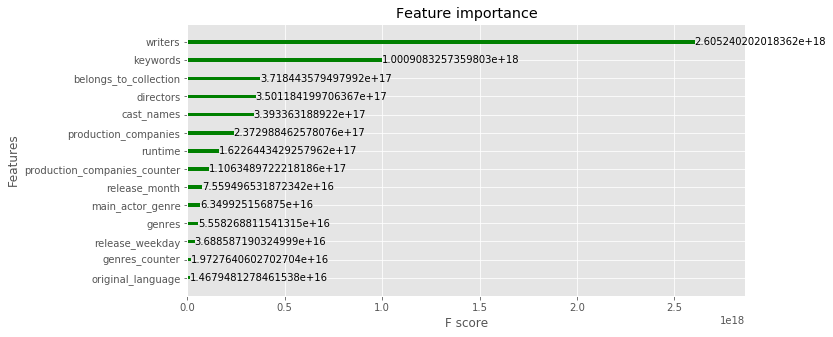

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgbo, ax = ax, importance_type = "gain", color = "green")
plt.show()

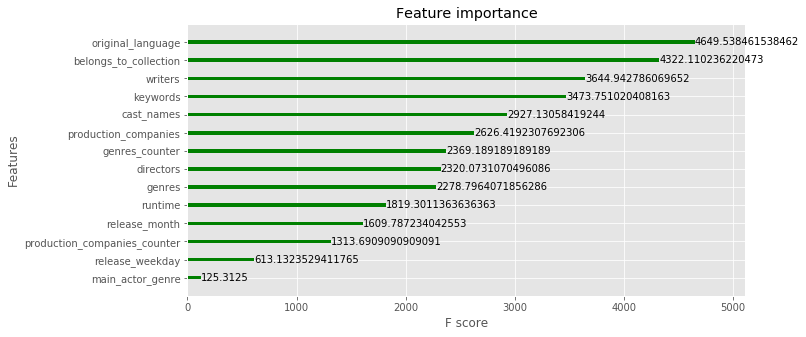

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgbo, ax = ax, importance_type = "cover", color = "green")
plt.show()

In [29]:
import shap

In [30]:
shap.initjs()
explainer = shap.TreeExplainer(xgbo)
shap_values = explainer.shap_values(X)

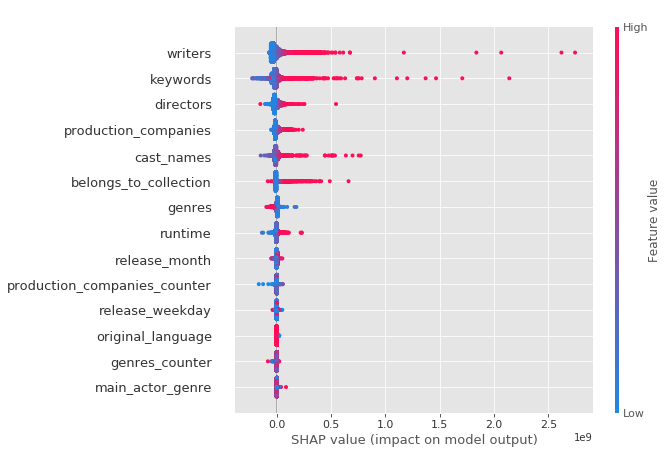

In [31]:
shap.summary_plot(shap_values, X)

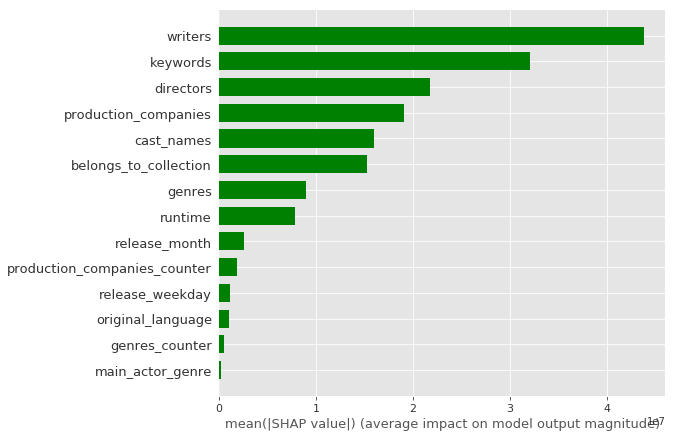

In [32]:
shap.summary_plot(shap_values, X, plot_type = "bar", color = "green")

Para explicar estas gráficas ver 
https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

Guardo el modelo en un archivo pickle

Para guardarlo y que no haya problemas con la nomenclatura de las columnas entreno el modelo únicamente con los valores y lo guardo

In [33]:
X = reves.drop(["revenue_inflated"], axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
xgbo = XGBRegressor(n_estimators = 400, max_depth = 3)
xgbo.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [34]:
print(mean_absolute_error(y_test, y_pred))
print(explained_variance_score(y_pred, y_test))
print(xgbo.score(X_test, y_test))

29715379.9537
0.950786460533
0.954596685307


In [35]:
import pickle
pickle.dump(xgbo, open("xgbo_model.pkl", "wb"))